In [12]:
# dataframe and array
import pandas as pd
import numpy as np
from scipy import interp

# plot
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

# sklearn
from sklearn.model_selection import cross_val_predict, cross_val_score, train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc, precision_recall_curve,accuracy_score, precision_score, recall_score,f1_score
from sklearn.preprocessing import StandardScaler

# Classifiers
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier

import xgboost as xgb

# for hyperopt
from hyperopt import tpe
from hpsklearn import HyperoptEstimator, any_classifier

# for sampling
from imblearn.over_sampling import SMOTE


# 扩展同时支持多个分数输出
from multiscorer import MultiScorer  #https://github.com/StKyr/multiscorer/
import time

from itertools import cycle

### the dataset

In [2]:
data = pd.read_csv("D://datasource/creditcard.csv")
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
# 对其他变量不做过多处理
data['normAmount'] = StandardScaler().fit_transform(data['Amount'].reshape(-1, 1))
data = data.drop(['Time','Amount'],axis=1)
data.head()

C:\Users\lakala\Anaconda2\lib\site-packages\ipykernel\__main__.py:2: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  from ipykernel import kernelapp as app


,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Class,normAmount
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,0.244964
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,-0.342475
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,1.160686
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,0.140534
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,-0.073403


### sampling

In [4]:
from __future__ import division
# =================================================全量

X = data.iloc[:, data.columns != 'Class']
y = data.iloc[:, data.columns == 'Class']
# Showing ratio
print ('For whole dataset')
print("Percentage of normal transactions: ", len(data[data.Class == 0])/len(data))
print("Percentage of fraud transactions: ", len(data[data.Class == 1])/len(data))
print("Total number of transactions in data: ", len(data))

# train test split for whole dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=886)

# =================================================欠抽样
# Number of data points in the minority class
number_records_fraud = len(data[data.Class == 1])
fraud_indices = np.array(data[data.Class == 1].index)

# Picking the indices of the normal classes
normal_indices = data[data.Class == 0].index

# Out of the indices we picked, randomly select "x" number (number_records_fraud)
random_normal_indices = np.random.choice(normal_indices, number_records_fraud, replace = False)
random_normal_indices = np.array(random_normal_indices)

# Appending the 2 indices
under_sample_indices = np.concatenate([fraud_indices,random_normal_indices])

# Under sample dataset
under_sample_data = data.iloc[under_sample_indices,:]

X_undersample = under_sample_data.iloc[:, under_sample_data.columns != 'Class']
y_undersample = under_sample_data.iloc[:, under_sample_data.columns == 'Class']

# train test split for undersample dataset
X_train_usample, X_test_usample, y_train_usample, y_test_usample = train_test_split(X_undersample, y_undersample, test_size=0.3, random_state=886)

# Showing ratio
print ('For undersample')
print("Percentage of normal transactions: ", len(under_sample_data[under_sample_data.Class == 0])/len(under_sample_data))
print("Percentage of fraud transactions: ", len(under_sample_data[under_sample_data.Class == 1])/len(under_sample_data))
print("Total number of transactions in resampled data: ", len(under_sample_data))


# =================================================SMOTE
oversampler = SMOTE(random_state=0)
X_oversample, y_oversample = oversampler.fit_sample(X, y)

# back to df
X_oversample = pd.DataFrame(X_oversample, columns=X.columns)
y_oversample = pd.DataFrame(y_oversample, columns=y.columns)

# train test split for undersample dataset
X_train_osample, X_test_osample, y_train_osample, y_test_osample = train_test_split(X_oversample, y_oversample, test_size=0.3, random_state=886)


# Showing ratio
print ('\nFor oversample')
print("Percentage of normal transactions: ", len(y_oversample[y_oversample.Class == 0])/len(y_oversample))
print("Percentage of fraud transactions: ", len(y_oversample[y_oversample.Class == 1])/len(y_oversample))
print("Total number of transactions in resampled data: ", len(y_oversample))

For whole dataset
('Percentage of normal transactions: ', 0.9982725143693799)
('Percentage of fraud transactions: ', 0.001727485630620034)
('Total number of transactions in data: ', 284807)
For undersample
('Percentage of normal transactions: ', 0.5)
('Percentage of fraud transactions: ', 0.5)
('Total number of transactions in resampled data: ', 984)


C:\Users\lakala\Anaconda2\lib\site-packages\sklearn\utils\validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



For oversample
('Percentage of normal transactions: ', 0.5)
('Percentage of fraud transactions: ', 0.5)
('Total number of transactions in resampled data: ', 568630)


### model selection 

In [5]:
# load the testing dataset
from sklearn.datasets import load_iris
iris = load_iris()

In [6]:
# cross_val_score
clf = RandomForestClassifier()
cross_val_score(clf, iris.data, iris.target, cv=5) #5-fold cv

# 5折fold
# 默认输出score为准确率

array([ 0.96666667,  0.96666667,  0.96666667,  0.93333333,  1.        ])

In [7]:
# 直接使用dataframe作为输入
# 不接受dataframe直接输入
cross_val_score(clf, X.values, y.Class, cv=5) #5-fold cv

array([ 0.99903444,  0.99947333,  0.99915732,  0.99954355,  0.99947332])

In [12]:
# 可以用其他分数 如f1， auc
cross_val_score(clf, X, y.Class, cv=5, scoring='f1')

array([ 0.74439462,  0.85057471,  0.73743017,  0.82840237,  0.8       ])

In [19]:
models = [GaussianNB(), DecisionTreeClassifier(), SVC(), RandomForestClassifier()]
names = ["Naive Bayes", "Decision Tree", "SVM", "RF"]

scorer = MultiScorer({
    'Accuracy' : (accuracy_score, {}),
    'Precision' : (precision_score, {'pos_label': 3, 'average':'macro'}),
    'Recall' : (recall_score, {'pos_label': 3, 'average':'macro'}),
    'F1' : (f1_score, {'pos_label': 3, 'average':'macro'})  # 因为目标是三个类，不能用默认值
    'ROC_AUC' : (roc_auc_score, {})
})

for model, name in zip(models, names):
    print name
    start = time.time()

    cross_val_score(model, iris.data, iris.target,scoring=scorer, cv=10)
    results = scorer.get_results()

    for metric_name in results.keys():
        average_score = np.average(results[metric_name])
        scores = np.array(results[metric_name])
#         print("%s: %0.5f (+/- %0.3f)" % (metric_name, scores.mean(), scores.std() * 2))
        print('%s : %f' % (metric_name, average_score))

    print 'time', time.time() - start, '\n\n'

Naive Bayes
Recall: 0.95333 (+/- 0.085)
Accuracy: 0.95333 (+/- 0.085)
Precision: 0.96270 (+/- 0.065)
F1: 0.95244 (+/- 0.088)
time 0.058000087738 


Decision Tree
Recall: 0.95333 (+/- 0.085)
Accuracy: 0.95333 (+/- 0.085)
Precision: 0.96079 (+/- 0.073)
F1: 0.95272 (+/- 0.087)
time 0.050999879837 


SVM
Recall: 0.96222 (+/- 0.082)
Accuracy: 0.96222 (+/- 0.082)
Precision: 0.96831 (+/- 0.070)
F1: 0.96175 (+/- 0.083)
time 0.0570001602173 


RF
Recall: 0.96333 (+/- 0.079)
Accuracy: 0.96333 (+/- 0.079)
Precision: 0.96929 (+/- 0.067)
F1: 0.96289 (+/- 0.080)
time 0.694999933243 




In [20]:
# 比较不同的抽样
print "全抽样"
for model, name in zip(models, names):
    print name
    start = time.time()

    cross_val_score(model, X, y.Class,scoring=scorer, cv=10)
    results = scorer.get_results()

    for metric_name in results.keys():
        average_score = np.average(results[metric_name])
        scores = np.array(results[metric_name])
        print("%s: %0.5f (+/- %0.3f)" % (metric_name, scores.mean(), scores.std() * 2))
#         print('%s : %f' % (metric_name, average_score))

    print 'time', time.time() - start, '\n\n'


全抽样
Naive Bayes
Recall: 0.95135 (+/- 0.095)
Accuracy: 0.96620 (+/- 0.071)
Precision: 0.88153 (+/- 0.356)
F1: 0.88060 (+/- 0.337)
time 4.77699995041 


Decision Tree
Recall: 0.93432 (+/- 0.123)
Accuracy: 0.97160 (+/- 0.069)
Precision: 0.87293 (+/- 0.335)
F1: 0.87226 (+/- 0.315)
time 333.355999947 


SVM
Recall: 0.90698 (+/- 0.187)
Accuracy: 0.97552 (+/- 0.067)
Precision: 0.88239 (+/- 0.318)
F1: 0.86239 (+/- 0.302)
time 6352.273 


RF
Recall: 0.90108 (+/- 0.186)
Accuracy: 0.97849 (+/- 0.065)
Precision: 0.89065 (+/- 0.304)
F1: 0.86590 (+/- 0.286)
time 399.816999912 




### 总体分析
Get univariate summary statistics of data:
* Non-NA values for all variables
* The 5 most frequent values for all variables
* Mean, standard error, and quantiles for numeric variables

数据清洗前的准备工作，了解自己面对的数据的特征：
* 变量类型
* 变量的空值、非空值数量
* 变量出现频数前5大的值与数量，与其他值的数量（尾巴）
* 数值变量的统计量：均值，方差，四分位数（含最值）

为什么进行数据清洗
* 模型向往的是分布良好的数值，数据却有着骨感的现实
    * 空缺，类别（字符串）。。。模型陷进了Bug中
    * 稀疏性，共线性，极端值。。。模型迷失在数学难题中
    * 时间，地理名称等。。。模型在人类知识面前踌躇不进
    
变量太多，如何自动清洗？-- 搭建5步法依次批量完成清洗
* 数值变量保留，非数值变量全部转为数值变量：
    * 有额外信息的非数值变量转化为对应的数值：时间-》年月日周、相对天数
    * 地名-》经纬度，城市等级
    * 定序变量-》序数
    * 其余非数值变量全部转为0-1哑变量
* 选取统计量去概况一系列相似变量：取中位数，方差，求和，最值，空值等找到一些相似变量
* 删除稀疏变量：空值、同一值占绝大比例（如99.9%）的列
* 删除共线性变量：相关系数接近1的列
* 用中位数填充空值，最后正态标准化：rank与正态分布的百分位函数复合

一些答疑：
* 为何选用中位数而不是平均数填充空值？
    * 数据分布不对称时，中位数比平均数更能保持排序关系
* 为何进行正态标准化，而不是中心归一标准化
    * 是为了应对实际数据的大量有偏分布和极端值
        * 出发点：决策树集成类模型不依赖于数据分布，预测效果往往好；反而考虑分布信息的模型经常受分布偏差的负面影响；
        * 正态标准化特点：只保留排序关系，彻底去除有偏分布和极端值，在大样本下直接满足众多模型假设
        * 在本数据集能明显提高逻辑回归和神经网络的效果

In [ ]:
def Value_counts(das, nhead = 5):
    tmp = pd.value_counts(das).reset_index().rename_axis({"index": das.name}, axis = 1)
    value = pd.DataFrame(['value {}'.format(x+1) for x in range(nhead)], index = np.arange(nhead)).join(tmp.iloc[:,0], how = "left").set_index(0).T
    freq = pd.DataFrame(['freq {}'.format(x+1) for x in range(nhead)], index = np.arange(nhead)).join(tmp.iloc[:,1], how = "left").set_index(0).T
    nnull = das.isnull().sum()
    freqother = pd.DataFrame({das.name: [das.shape[0]-nnull-np.nansum(freq.values), nnull]}, index = ["freq others", "freq NA"]).T
    op = pd.concat([value, freq, freqother], axis = 1)
    return(op)
def Summary(da):
    op = pd.concat([pd.DataFrame({"type": da.dtypes, "n": da.notnull().sum(axis = 0)}), da.describe().T.iloc[:,1:], 
                    pd.concat(map(lambda i: Value_counts(da.loc[:,i]), da.columns))], axis = 1).loc[da.columns]
    op.index.name = "Columns"
    return(op)


## 用法
Summary(da).to_csv("{}/{}_summary_da.csv".format(path, title))

In [ ]:
def Col_group(ic, i = 0):
    cols = pd.Series([x.split("_")[i] for x in ic], index = ic)
    return(cols)
daa = pd.read_csv("{}/{}_daa.csv".format(path, title), index_col = "Column")["Type"]
daacity0 = pd.read_csv("{}/cnd_da_city_{}.csv".format(path, 0), encoding = "GB18030", index_col = 0)
daacity1 = pd.read_csv("{}/cnd_da_city_{}.csv".format(path, 1), encoding = "GB18030",
                       converters = {"Prov": Del_string, "City": Del_string, "District": Del_string})
daacity1= (pd.concat(map(lambda i: daacity1.drop_duplicates([i]).set_index([i]).iloc[:,2:], ["Prov", "City", "District"]))
            .reset_index().drop_duplicates(["index"]).set_index(["index"]))
daacity = daacity1.join(daacity0, how = "left")
ictype = {"y": ["target"],
          "date": ["ListingInfo"], 
          "catmap": ["UserInfo_{}".format(i) for i in [2, 4, 8, 20, 7, 19]],
          "catmapd": [daacity]*6,
          }
ictype["cols"] = Col_group(da.drop(ictype["y"], axis = 1).columns)
tmp = ictype["cols"].index[ictype["cols"] == "ThirdParty"]
ictype["serials"] = pd.Series(["_".join([x.split("_")[i] for i in [0,1,3]]) for x in tmp], index = tmp)
ictype["catbin"] = list((set(daa.index[daa == "Categorical"])|set(da.columns[da.dtypes == "O"])) - set(ictype["catmap"]))

In [ ]:
def Time_to_num(das):
    tmp = pd.DatetimeIndex(das)
    daop = pd.DataFrame(dict(zip(*[["{}_{}".format(das.name, i) for i in ["Day", "Year", "DayofYear", "DayofMonth", "DayofWeek"]], 
                                   [(das - das.min()).astype('timedelta64[D]').astype(int), tmp.year, tmp.dayofyear, tmp.day, tmp.dayofweek]])),
                        index = das.index)
    return(daop)
def Cat_map(das, damap, fillna = {"CityRank":6}):
    daop = das.reset_index().set_index([das.name]).join(damap, how = "left").set_index(das.index.name).reindex(das.index).fillna(fillna)
    daop.columns = ["{}_{}".format(das.name, i) for i in damap.columns]
    return(daop)
def Cat_to_bin(das, a = 0.01):
    '''Transfrom a categorical column to onehotencoding'''
    tmp = pd.value_counts(das)/das.shape[0]
    cat = list(tmp.index[tmp > a])
    enc = prep.OneHotEncoder(n_values = len(cat)+1, sparse = False)
    xbin = enc.fit_transform(np.transpose(
            [das.astype("category").cat.set_categories(cat).cat.rename_categories(1+np.arange(len(cat))).astype("float").fillna(0).values]))[:,1:]     
    dabin = pd.DataFrame(xbin, columns = ["{}_{}".format(das.name, x) for x in cat], index = das.index)    
    if(tmp[tmp <= a].sum() > a):
        dabin = pd.concat([dabin, pd.DataFrame({"{}_Others".format(das.name):das.notnull()-dabin.sum(axis = 1)})], axis = 1)
    if(dabin.shape[1] == 2):
        dabin = pd.DataFrame({das.name: xbin[:,0]}, index = das.index)
    return(dabin)
def Append_col_name(da, name):
    return(da.rename(columns = dict(zip(*[list(da.columns), ["{}_{}".format(x, name) for x in da.columns]]))))
def ColS_fillna(da, cols, f = "median", allNA = 0):
    dafill = getattr(da[cols.index].groupby(cols, axis = 1), f)()[cols]
    dafill.columns = cols.index
    daop = da[cols.index].fillna(dafill).fillna(allNA)
    return(daop)
def ColS_summary(da, cols, f = ["median", "std"]):
    grp = da[cols.index].groupby(cols, axis = 1)
    daop = pd.concat(map(lambda x: Append_col_name(getattr(grp, x)(), x), f), axis = 1)
    return(daop)
def Clean_data(da, ictype, a = 0.01):
    '''Transform and clean columns according to types'''
    dac = da.copy().replace([-np.inf, np.inf], np.nan).replace("不详", np.nan)
    dac.loc[:, "UserInfo_20"] = dac.loc[:, "UserInfo_20"].fillna(dac.loc[:, "UserInfo_19"])
    datime = pd.concat(map(lambda i: Time_to_num(dac.loc[:,i]), ictype["date"]), axis = 1)
    dacatmap = pd.concat(map(lambda i: Cat_map(dac.loc[:,ictype["catmap"][i]], ictype["catmapd"][i]), range(len(ictype["catmap"]))), axis = 1)
    dacatmap = pd.concat([dacatmap.iloc[:,15:20], ColS_summary(dacatmap, 
        pd.Series(["_".join([x.split("_")[i] for i in [0,2]]) for x in dacatmap.columns[:15]], index = dacatmap.columns[:15]))], axis = 1)
    dacatbin  = pd.concat(map(lambda i: Cat_to_bin(dac.loc[:,i], a = a), ictype["catbin"]+[ictype["catmap"][-1]]), axis = 1)
    daS = ColS_summary(dac, ictype["serials"], ["median", "std", "min", "max", "first"]).fillna(0)
    cols = Col_group(daS.columns, i = -1)
    daS.loc[:,cols == "max"] = daS.loc[:,cols == "max"] - daS.loc[:,cols == "median"].values
    dacount = ColS_summary(dac, ictype["cols"], ["count"])
    dac = pd.concat([dac.drop(ictype["date"] + ictype["catmap"] + ictype["catbin"] + list(ictype["serials"].index), axis = 1), 
                     datime, dacatmap, dacatbin, daS, dacount], axis = 1)
    tmp = pd.concat(map(lambda i: Value_counts(dac.loc[:,i]), dac.columns))
    dac = dac.loc[:, (tmp["freq 1"] + tmp["freq NA"])/dac.shape[0] < 1 - a]
    dac = dac.drop(dac.columns[np.any(np.abs(np.tril(np.corrcoef(dac.rank(pct = True).fillna(0.5).values, rowvar = 0), -1)) > 0.99, axis = 0)], axis = 1)
    return(dac)

In [ ]:
dac = Clean_data(da, ictype, a = 0.001)
Summary(dac).to_csv("{}/{}_summary_dac.csv".format(path, title))
dac.shape

### 单变量分析

In [17]:
# 对于联系变量倾向于使用柱状和密度图查看区别，另外就是箱图
# Histograms
def showHist(df, columns):
    '''
    columns is the cols you want to check;
    df is the source df;
    '''
    plt.figure(figsize=(18, len(columns) * 5))  # 全图大小
    gs = gridspec.GridSpec(len(columns), 1)     # 网格
    for i, col in enumerate(df.loc[:, columns]):
        ax = plt.subplot(gs[i])   # 分图在网格中的位置
        sns.distplot(df[col][df.Class == 1], bins=50, label='Fraud', color='tomato')
        sns.distplot(df[col][df.Class == 0], bins=50, label='Normal', color='teal')
        ax.set_xlabel('')
        ax.set_title('histogram of feature: ' + str(col))
        plt.legend(loc='best')

    plt.show()


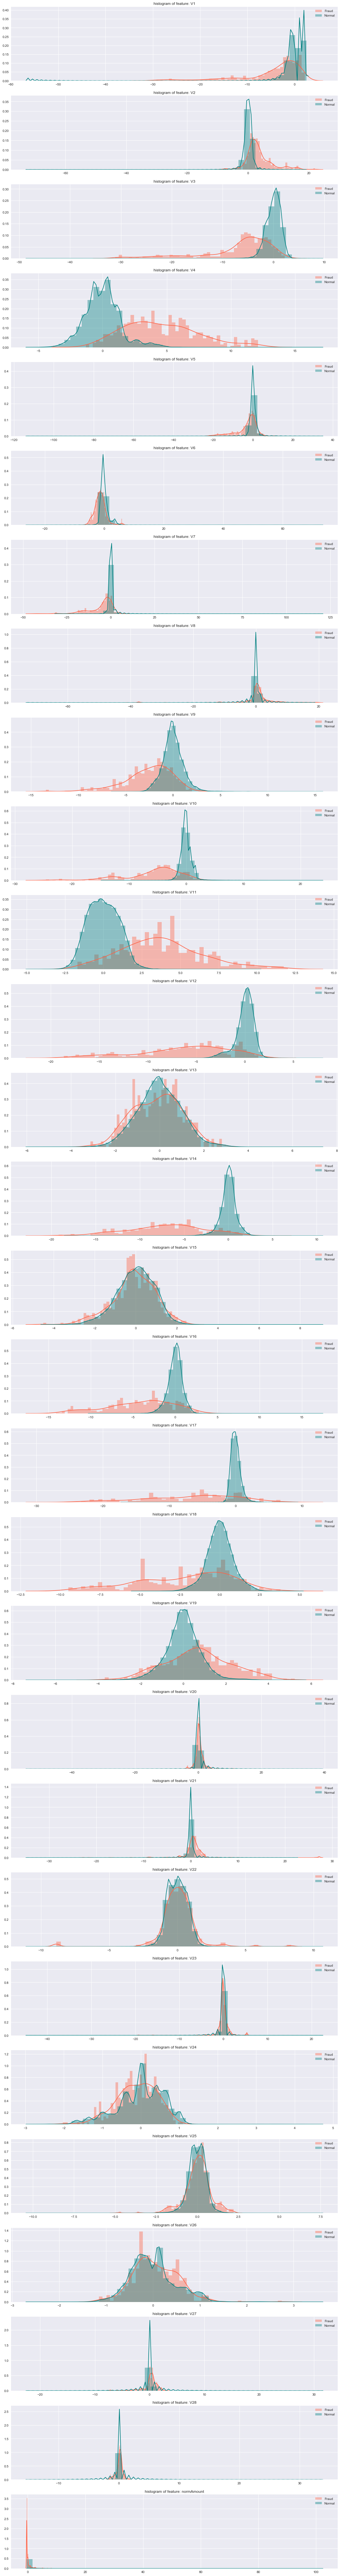

In [18]:
his_cols = list(data.columns)
his_cols.remove('Class')  # remove the Y
showHist(data, his_cols)

In [5]:
# 此处发现sns貌似有个bug
# 不能直接使用sns.violinplot(x, y, data, palette='Set2', split='True', orient='V')的新api
# 跑了很久都没有跑出来
# https://seaborn.pydata.org/generated/seaborn.violinplot.html
# 效率的bug使用旧接口解决：https://stackoverflow.com/questions/25284859/grouping-boxplots-in-seaborn-when-input-is-a-dataframe

def showViolin(df, columns):
    '''
    columns is the cols you want to check;
    df is the source df;
    '''
    plt.figure(figsize=(10, len(columns) * 6))  # 全图大小
    gs = gridspec.GridSpec(len(columns), 1)     # 网格
    for i, col in enumerate(df.loc[:, columns]):
        ax = plt.subplot(gs[i])   # 分图在网格中的位置
#         sns.distplot(data[col][data.Class == 1], bins=50, label='Fraud', color='tomato')
#         sns.distplot(data[col][data.Class == 0], bins=50, label='Normal', color='teal')
        sns.violinplot(df[col], groupby=df.Class, palette='Set2', split='True', orient='V')
        ax.set_xlabel('')
        ax.set_ylabel('')
        ax.set_title('ViolinPlot of feature: ' + str(col))
        plt.legend(loc='best')
    plt.show()

C:\Users\lakala\Anaconda2\lib\site-packages\seaborn\categorical.py:2342: UserWarning: The violinplot API has been changed. Attempting to adjust your arguments for the new API (which might not work). Please update your code. See the version 0.6 release notes for more info.
  warnings.warn(msg, UserWarning)
C:\Users\lakala\Anaconda2\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


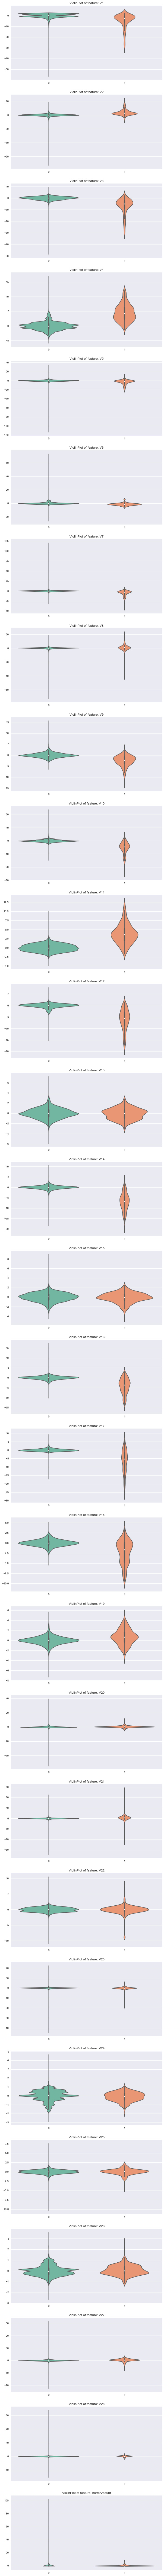

In [6]:
his_cols = list(data.columns)
his_cols.remove('Class')  # remove the Y
showViolin(data, his_cols)

#### 相关性分析

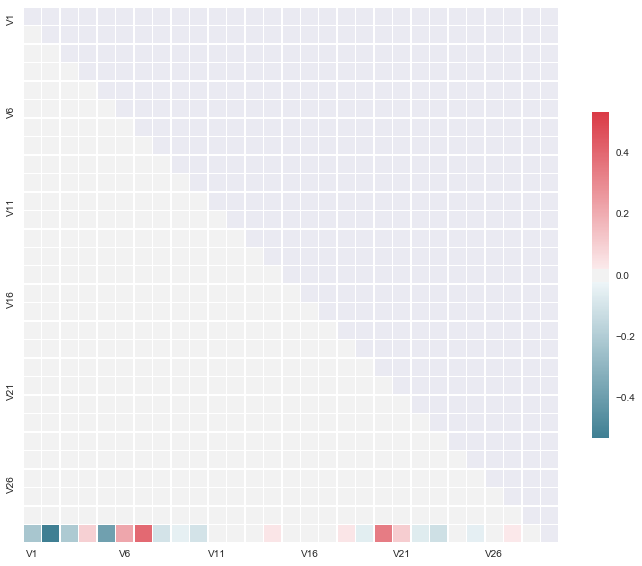

In [10]:
# Correlations
corr = X.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 12))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3,
            square=True, xticklabels=5, yticklabels=5,
            linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)
plt.show()

# c.f. 
# As the description on data said, V1 ~ V28 are PCA reduced.
# Thus, no correlation between them.

### 调参

#### 1. 使用GV调参

In [ ]:
#applying gridsearchCV to our classifier
#Specifying the parameters in dictionaries to try out different parameters.
#The GridSearchCV will try all the parameters and give us the best parameters

classifier= SVC(C= 1, kernel= 'rbf', random_state= 0)

parameters = [{'C': [1, 10, 100, 1000], 'kernel': ['linear']},
              {'C': [1, 10, 100, 1000], 'kernel': ['rbf'], 'gamma': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]}]

grid_search = GridSearchCV(estimator = classifier,
                           param_grid = parameters,
                           scoring = 'accuracy',   # 这里scoring建议f1
                           cv = 10,
                           n_jobs = -1)
grid_search = grid_search.fit(X_train, y_train.ravel())  # 这里同时有不同的dataset可以设置
best_accuracy = grid_search.best_score_
print("The best accuracy using gridSearch is", best_accuracy)

best_parameters = grid_search.best_params_
print("The best parameters for using this model is", best_parameters)


# 使用gv得到的参数建模
#fitting the model with the best parameters
classifier_with_best_parameters =  SVC(C= best_parameters["C"], kernel= best_parameters["kernel"], random_state= 0)
classifier_with_best_parameters.fit(X_train, y_train.ravel())
#predicting the Class 
y_pred_best_parameters = classifier_with_best_parameters.predict(X_test)

In [ ]:
# 当参数有很多的时候可以分段进行参数调试
# 另外一个原则是使用训练集进行模型的调参
# 以下是xgb的调参过程


cv_params = {'max_depth': [1,2,3,4,5,6], 'min_child_weight': [1,2,3,4]}    # parameters to be tried in the grid search
fix_params = {'learning_rate': 0.2, 'n_estimators': 100, 'objective': 'binary:logistic'}   #other parameters, fixed for the moment 
csv = GridSearchCV(xgb.XGBClassifier(**fix_params), cv_params, scoring = 'f1', cv = 5)
# 目标参数是f1， 后续可以设置为roc来进行 多个角度进行参数的选取

csv.fit(X_, y_)
csv.grid_scores_        # 该方法能打印每一个参数组合的分数输出
csv.best_params_        #  输出最优参数


cv_params = {'subsample': [0.8,0.9,1], 'max_delta_step': [0,1,2,4,8]}
fix_params = {'learning_rate': 0.2, 'n_estimators': 100, 'objective': 'binary:logistic', 'max_depth': 5, 'min_child_weight':3}
csv = GridSearchCV(xgb.XGBClassifier(**fix_params), cv_params, scoring = 'f1', cv = 5) 
csv.fit(X_, y_)
csv.best_params_


cv_params = {'learning_rate': [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35]}
fix_params['max_delta_step'] = 0
fix_params['subsample'] = 0.9
csv = GridSearchCV(xgb.XGBClassifier(**fix_params), cv_params, scoring = 'f1', cv = 5) 
csv.fit(X_, y_)


# 最后
fix_params['learning_rate'] = 0.25
params_final =  fix_params
print(params_final)

#{'learning_rate': 0.25, 'n_estimators': 100, 'objective': 'binary:logistic', 'max_depth': 5, 'min_child_weight': 3, 'max_delta_step': 0, 'subsample': 0.9}

#### 2.作图调参

In [ ]:
# 有时候我们需要的是某个指标达到标准后 去最优化其他指标

# 例如欺诈模型中 我们假设我们的目标recall是0.8，这时候我们指定的目标下 最小化FPR

# 参考https://github.com/dstuerzer/Kaggle/tree/master/credit_card_fraud

def get_curves(X_, y_, pars):
    # pars 是模型需要用的参数
    X_train, X_val, y_train, y_val = train_test_split(X_, y_, test_size = 0.2)
    clf = xgb.XGBClassifier(**pars)
    clf.fit(X_train, y_train)
    y_prob = clf.predict_proba(X_val)[:,clf.classes_[1]]
    fpr, tpr, thresholds_roc = roc_curve(y_val, y_prob)
    prec, rec, thresholds_pr = precision_recall_curve(y_val, y_prob)
    return fpr, tpr, prec, rec


def gen_curves(X_, y_, pars):  # 这个方法只要是实现多个迭代取均值
    N_iter = 300
    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100000)
    
    mean_prec = 0.0
    mean_rec = np.linspace(0, 1, 100000)
    
    for n in range(N_iter):
        fpr, tpr, prec, rec = get_curves(X_, y_, pars)
        prec = list(reversed(prec)) #reverse, otherwise the interp doesn not work
        rec = list(reversed(rec))
        mean_tpr  += np.interp(mean_fpr, fpr, tpr)
        mean_prec += np.interp(mean_rec, rec, prec)

    mean_tpr /= N_iter
    mean_prec /= N_iter
    
    return mean_fpr, mean_tpr, mean_prec, mean_rec


def plot_roc(X_, y_, par, name_par, list_par):   # 这方法就是用来画图
    f, (ax1, ax2) = plt.subplots(1, 2, figsize = (20,14));
    for l in list_par:
        par[name_par] = l
        print(par)
        mean_fpr, mean_tpr, mean_prec, mean_rec = gen_curves(X_, y_, par)
        ax1.plot(mean_fpr, mean_tpr, label = name_par+" = "+str(l))
        ax2.plot(mean_rec, mean_prec, label = name_par+" = "+str(l))
    ax1.set_xlim([0, 0.0005])
    ax1.set_ylim([0.6, 0.85])
    ax1.axvline(2e-4, color='b', linestyle='dashed', linewidth=2)
    ax1.legend(loc="lower right")
    ax1.set_xlabel('FPR/Fallout')
    ax1.set_ylabel('TPR/Recall')
    ax2.set_xlabel('Recall')
    ax2.set_ylabel('Precision')
    ax1.set_title('ROC')
    ax2.set_title('PR')
    ax2.legend(loc = "lower left")
    ax2.set_xlim([0.75, 0.95])
    plt.show()
    
# 用法
plot_roc(X_, y_, par, 'max_depth', [1,2,3,4,5,7,10,15])

### 效果图形化

#### AUC

In [1]:
# 对比多个模型啊auc  -- > 可以用上面的k折 cross_val_score进行对比

# 使用cv，查看多个fold状态下的auc表现

def plot_roc_cv(classifier, X, y):
    cv = StratifiedKFold(n_splits=6)
    
    mean_tpr = 0.0   # 记录cv下的均值
    mean_fpr = np.linspace(0, 1, 100)

    colors = cycle(['cyan', 'indigo', 'seagreen', 'yellow', 'blue', 'darkorange'])
    lw = 2

    i = 0
    for (train, test), color in zip(cv.split(X, y), colors):
        probas_ = classifier.fit(X[train], y[train]).predict_proba(X[test])
        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
        mean_tpr += interp(mean_fpr, fpr, tpr)
        mean_tpr[0] = 0.0
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=lw, color=color,
                 label='ROC fold %d (area = %0.2f)' % (i, roc_auc))

        i += 1
    plt.plot([0, 1], [0, 1], linestyle='--', lw=lw, color='k',
             label='Luck')

    mean_tpr /= cv.get_n_splits(X, y)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    plt.plot(mean_fpr, mean_tpr, color='g', linestyle='--',
             label='Mean ROC (area = %0.2f)' % mean_auc, lw=lw)

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    plt.show()
    
    
# 用法
# 如果是dataframe直接输入需要用values

plot_roc_cv(classifier, X_df.values, y_df.flag)

In [ ]:
# source : 
# http://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html#sphx-glr-auto-examples-model-selection-plot-roc-crossval-py

def plot_roc_cv_mean(classifier, X, y):
    cv = StratifiedKFold(n_splits=6)
    
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    i = 0
    for train, test in cv.split(X, y):
        probas_ = classifier.fit(X[train], y[train]).predict_proba(X[test])
        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        plt.plot(fpr, tpr, lw=1, alpha=0.3,
                 label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

        i += 1
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
             label='Luck', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    plt.plot(mean_fpr, mean_tpr, color='b',
             label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
             lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                     label=r'$\pm$ 1 std. dev.')

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

#### confusion matrix



In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        1#print('Confusion matrix, without normalization')

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
# 食用方法


lr = LogisticRegression(C = best_c, penalty = 'l1')
lr.fit(X_train_undersample,y_train_undersample.values.ravel())
y_pred_undersample = lr.predict(X_test_undersample.values)

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test_undersample,y_pred_undersample)
np.set_printoptions(precision=2)

print("Recall metric in the testing dataset: ", cnf_matrix[1,1]/float((((cnf_matrix[1,0]+cnf_matrix[1,1])))))
# Plot non-normalized confusion matrix
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix
                      , classes=class_names
                      , title='Confusion matrix')
plt.show()

print ('---classification_report---')
print classification_report(y_test_undersample,y_pred_undersample)

#### Feature importances with forests of trees

In [ ]:
# source：
# http://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html#sphx-glr-auto-examples-ensemble-plot-forest-importances-py

def plot_feature_imp(forest, X, y):
    # forest can be RF or extratreesclassifier
    
    forest.fit(X, y)
    importances = forest.feature_importances_
    std = np.std([tree.feature_importances_ for tree in forest.estimators_],
                 axis=0)
    indices = np.argsort(importances)[::-1]

    # Print the feature ranking
    print("Feature ranking:")

    for f in range(X.shape[1]):
        print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

    # Plot the feature importances of the forest
    plt.figure()
    plt.title("Feature importances")
    plt.bar(range(X.shape[1]), importances[indices],
           color="r", yerr=std[indices], align="center")
    plt.xticks(range(X.shape[1]), indices)
    plt.xlim([-1, X.shape[1]])
    plt.show()

#### OOB errors

Though the number of trees isn't a tuning parameter, you do need to know how many trees you need for a stable solution. Producing this plot will give you a good idea about how many trees you need. 

I would use it before the parameter search to give a vague idea of the tree settings to search (I try a few of my grid search settings and produce this plot). Then once, the optimum parameters are found, I do it once more to check if I cant eek out any more performance by growing the forest a bit larger. It's also very useful to check to see how class performance changes (see rgb lines on my plot).

In [ ]:
def plot_rf_oob(X, y, RANDOM_STATE=886):
    # NOTE: Setting the `warm_start` construction parameter to `True` disables
    # support for parallelized ensembles but is necessary for tracking the OOB
    # error trajectory during training.
    ensemble_clfs = [
        ("RandomForestClassifier, max_features='sqrt'",
            RandomForestClassifier(warm_start=True, oob_score=True,
                                   max_features="sqrt",
                                   random_state=RANDOM_STATE)),
        ("RandomForestClassifier, max_features='log2'",
            RandomForestClassifier(warm_start=True, max_features='log2',
                                   oob_score=True,
                                   random_state=RANDOM_STATE)),
        ("RandomForestClassifier, max_features=None",
            RandomForestClassifier(warm_start=True, max_features=None,
                                   oob_score=True,
                                   random_state=RANDOM_STATE))
    ]

    # Map a classifier name to a list of (<n_estimators>, <error rate>) pairs.
    error_rate = OrderedDict((label, []) for label, _ in ensemble_clfs)

    # Range of `n_estimators` values to explore.
    min_estimators = 15
    max_estimators = 500

    for label, clf in ensemble_clfs:
        for i in range(min_estimators, max_estimators + 1):
            clf.set_params(n_estimators=i)
            clf.fit(X, y)

            # Record the OOB error for each `n_estimators=i` setting.
            oob_error = 1 - clf.oob_score_
            error_rate[label].append((i, oob_error))
            
    plt.figure(figsize=(12, 8))
    # Generate the "OOB error rate" vs. "n_estimators" plot.
    for label, clf_err in error_rate.items():
        xs, ys = zip(*clf_err)
        plt.plot(xs, ys, label=label)

    plt.xlim(min_estimators, max_estimators)
    plt.xlabel("n_estimators")
    plt.ylabel("OOB error rate")
    plt.legend(loc="upper right")
    plt.show()

#### Feature Selection

feature_selection.RFE : Feature ranking with recursive feature elimination.

feature_selection.RFECV : Feature ranking with recursive feature elimination and cross-validated selection of the best number of features.

In [ ]:
def plot_rfecv(estimator, X, y):
    # The "accuracy" scoring is proportional to the number of correct
    # classifications
    rfecv = RFECV(estimator=estimator, step=1, cv=StratifiedKFold(5),
                  scoring='accuracy')
    rfecv.fit(X, y)

    print("Optimal number of features : %d" % rfecv.n_features_)

    # Plot number of features VS. cross-validation scores
    plt.figure()
    plt.xlabel("Number of features selected")
    plt.ylabel("Cross validation score (nb of correct classifications)")
    plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
    plt.show()

待写：

http://scikit-learn.org/stable/auto_examples/model_selection/plot_validation_curve.html#sphx-glr-auto-examples-model-selection-plot-validation-curve-py

http://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html#sphx-glr-auto-examples-model-selection-plot-precision-recall-py

http://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html#sphx-glr-auto-examples-model-selection-plot-learning-curve-py

http://scikit-learn.org/stable/auto_examples/model_selection/plot_multi_metric_evaluation.html#sphx-glr-auto-examples-model-selection-plot-multi-metric-evaluation-py